# Sentiment Analysis: FastText + Classical ML

End-to-end sentiment classification using FastText embeddings with XGBoost and Random Forest.

**Pipeline:** Data loading (IMDB) → Preprocessing → FastText embeddings → Training → Evaluation

## 1. Setup & Install Dependencies

In [1]:

# !pip install -q fasttext xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import xgboost as xgb
import fasttext
import re

#2d projection
from sklearn.manifold import TSNE

# for dataset
import tensorflow as tf
from tensorflow.keras.datasets import imdb

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries ready")



✓ All libraries ready


## 2. Load IMDB Dataset

In [2]:
print("Loading IMDB dataset...")

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

X_train_text = np.array([decode_review(x) for x in x_train[:4000]])
X_test_text = np.array([decode_review(x) for x in x_test[:1500]])
y_train_label = y_train[:4000]
y_test_label = y_test[:1500]

df_train = pd.DataFrame({'review': X_train_text, 'sentiment': y_train_label})
df_test = pd.DataFrame({'review': X_test_text, 'sentiment': y_test_label})
df = pd.concat([df_train, df_test], ignore_index=True)

print("✓ IMDB dataset loaded")



print(f"\nDataset shape: {df.shape}")
print(f"\nSample reviews:")
for i in range(2):
    label = 'POSITIVE' if df['sentiment'].iloc[i] == 1 else 'NEGATIVE'
    print(f"\n[{label}] {df['review'].iloc[i][:100]}...")

print(f"\nLabel distribution:")
print(df['sentiment'].value_counts().to_dict())

Loading IMDB dataset...
✓ IMDB dataset loaded

Dataset shape: (5500, 2)

Sample reviews:

[POSITIVE] ? this film was just brilliant casting location scenery story direction everyone's really suited the...

[NEGATIVE] ? big hair big boobs bad music and a giant safety pin these are the words to best describe this terr...

Label distribution:
{0: 2768, 1: 2732}


### Data Visualization

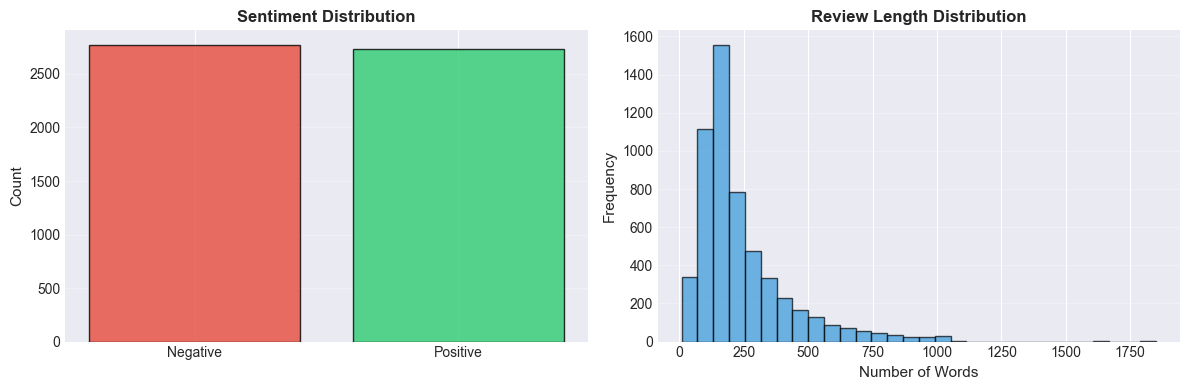

Review length statistics:
count    5500.000000
mean      241.746000
std       180.098601
min         9.000000
25%       129.000000
50%       180.000000
75%       295.000000
max      1851.000000
Name: review_length, dtype: float64


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sentiment_counts = df['sentiment'].value_counts().sort_index()
axes[0].bar(['Negative', 'Positive'], sentiment_counts.values, color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

df['review_length'] = df['review'].str.split().str.len()
axes[1].hist(df['review_length'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Words', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Review Length Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Review length statistics:")
print(df['review_length'].describe())

## 3. Text Preprocessing

In [4]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\\S+|www\\S+|https\\S+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z0-9\\s]', ' ', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

print("Preprocessing reviews...")

df_train['review_clean'] = df_train['review'].apply(preprocess_text)
df_test['review_clean']  = df_test['review'].apply(preprocess_text)

print("✓ Preprocessing complete!\n")

print("Sample transformations:")
for i in range(2):
    print(f"\nBefore: {df_train['review'].iloc[i][:80]}...")
    print(f"After:  {df_train['review_clean'].iloc[i][:80]}...")


Preprocessing reviews...
✓ Preprocessing complete!

Sample transformations:

Before: ? this film was just brilliant casting location scenery story direction everyone...
After:  this film was just brilliant casting location scenery story direction everyone s...

Before: ? big hair big boobs bad music and a giant safety pin these are the words to bes...
After:  big hair big boobs bad music and a giant safety pin these are the words to best ...


## 4. FastText Embeddings

In [5]:
train_data_path = './tmp/fasttext_train.txt'

print("Preparing FastText training data (train only)...")
with open(train_data_path, 'w') as f:
    for text, label in zip(df_train['review_clean'], df_train['sentiment']):
        f.write(f"__label__{int(label)} {text}\n")

print("✓ FastText training file created")


Preparing FastText training data (train only)...
✓ FastText training file created


In [6]:
print("Training FastText model...")
fasttext_model = fasttext.train_supervised(
    input=train_data_path,
    epoch=30,            # ↑ more learning
    lr=0.3,              # ↓ more stable
    wordNgrams=2,
    minn=3,              # character n-grams
    maxn=6,
    dim=300,             # ↑ richer embeddings
    loss='softmax',
    verbose=0
)

print("✓ FastText model trained!")
print(f"  Vocabulary size: {len(fasttext_model.get_words())}")
print(f"  Embedding dimension: 100")

Training FastText model...
✓ FastText model trained!
  Vocabulary size: 9789
  Embedding dimension: 100


In [7]:
print("Generating embeddings...")
X_train_embed = np.array([
    fasttext_model.get_sentence_vector(text)
    for text in df_train['review_clean']
])

X_test_embed = np.array([
    fasttext_model.get_sentence_vector(text)
    for text in df_test['review_clean']
])

y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

print("✓ Embeddings generated!")

Generating embeddings...
✓ Embeddings generated!


In [8]:
# Scale embeddings (REQUIRED)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_embed)
X_test  = scaler.transform(X_test_embed)

print(f"  Train embeddings shape: {X_train_embed.shape}")
print(f"  Test embeddings shape:  {X_test_embed.shape}")


  Train embeddings shape: (4000, 300)
  Test embeddings shape:  (1500, 300)


### Embedding Visualization (t-SNE)

In [9]:
print("Computing t-SNE projection...")

# Concatenate ONLY for visualization
embeddings_vis = np.vstack([X_train_embed, X_test_embed])
labels_vis = np.concatenate([y_train, y_test])

sample_size = min(1500, len(embeddings_vis))
sample_indices = np.random.choice(len(embeddings_vis), sample_size, replace=False)

X_sample = embeddings_vis[sample_indices]
y_sample = labels_vis[sample_indices]

tsne = TSNE(
    n_components=2,
    random_state=42,
    max_iter=1000,
    perplexity=30
)

X_2d = tsne.fit_transform(X_sample)

print("✓ t-SNE computed!")


Computing t-SNE projection...
✓ t-SNE computed!


## 5. Train-Test Split

In [10]:
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution (train):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'Positive' if label == 1 else 'Negative'
    print(f"  {label_name}: {count}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_embed)
X_test = scaler.transform(X_test_embed)

Training set: (4000, 300)
Test set: (1500, 300)

Class distribution (train):
  Negative: 1964
  Positive: 2036


## 6. Model Training

In [11]:
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.1,
    reg_alpha=0.01,
    reg_lambda=1.0,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)



y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Tune threshold (0.4–0.45 usually improves recall/F1)
threshold = 0.45
y_pred_xgb = (y_prob_xgb >= threshold).astype(int)
print("✓ XGBoost trained!")

Training XGBoost...
✓ XGBoost trained!


In [12]:
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("✓ Random Forest trained!")

Training Random Forest...
✓ Random Forest trained!


## 7. Model Evaluation

In [13]:
def evaluate_model(y_true, y_pred, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }
    return metrics

results = []
results.append(evaluate_model(y_test, y_pred_xgb, 'XGBoost'))
results.append(evaluate_model(y_test, y_pred_rf, 'Random Forest'))

results_df = pd.DataFrame(results)
print("\nMODEL PERFORMANCE")
print("="*75)
print(results_df.to_string(index=False))
print("="*75)


MODEL PERFORMANCE
        Model  Accuracy  Precision   Recall  F1-Score
      XGBoost  0.852667   0.826685 0.863506  0.844694
Random Forest  0.859333   0.836338 0.866379  0.851094


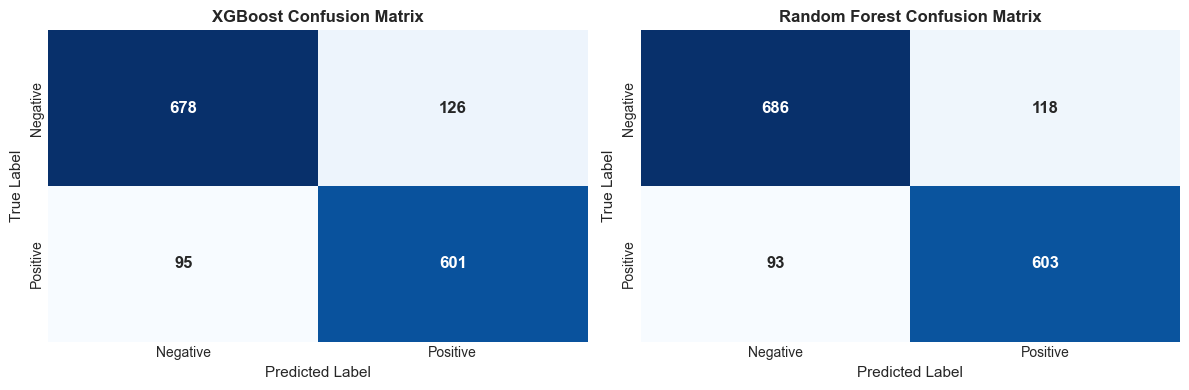

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

predictions = [
    ('XGBoost', y_pred_xgb),
    ('Random Forest', y_pred_rf)
]

for idx, (model_name, y_pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive'],
        cbar=False,
        annot_kws={'size': 12, 'weight': 'bold'}
    )
    axes[idx].set_title(f'{model_name} Confusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

In [15]:
print("\nDETAILED CLASSIFICATION REPORT - XGBoost")
print("="*75)
print(classification_report(
    y_test, y_pred_xgb,
    target_names=['Negative', 'Positive'],
    digits=4
))

print("\nDETAILED CLASSIFICATION REPORT - Random Forest")
print("="*75)
print(classification_report(
    y_test, y_pred_rf,
    target_names=['Negative', 'Positive'],
    digits=4
))


DETAILED CLASSIFICATION REPORT - XGBoost
              precision    recall  f1-score   support

    Negative     0.8771    0.8433    0.8599       804
    Positive     0.8267    0.8635    0.8447       696

    accuracy                         0.8527      1500
   macro avg     0.8519    0.8534    0.8523      1500
weighted avg     0.8537    0.8527    0.8528      1500


DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

    Negative     0.8806    0.8532    0.8667       804
    Positive     0.8363    0.8664    0.8511       696

    accuracy                         0.8593      1500
   macro avg     0.8585    0.8598    0.8589      1500
weighted avg     0.8601    0.8593    0.8595      1500



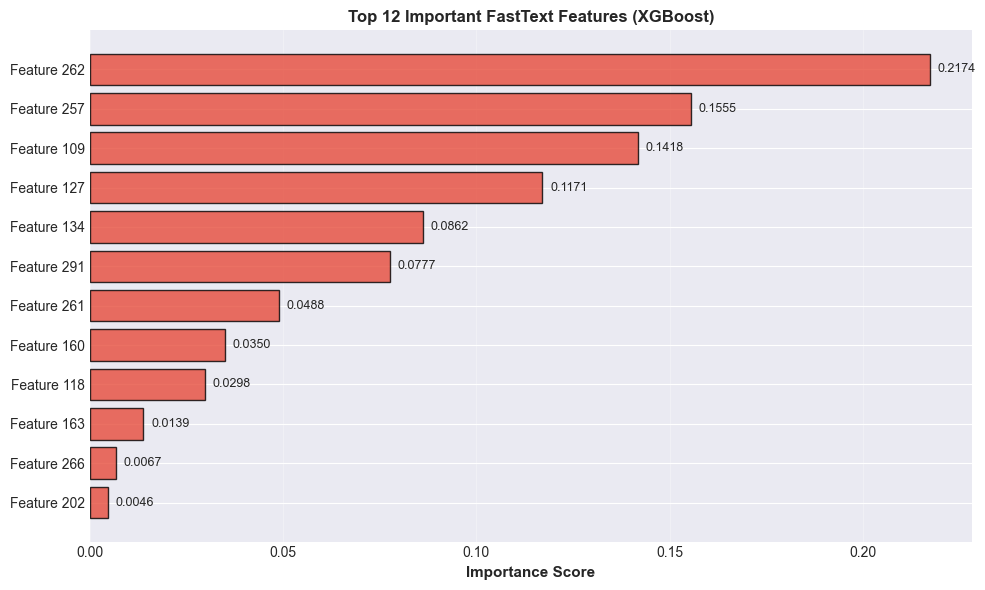

In [16]:
importance_xgb = xgb_model.feature_importances_
importance_indices = np.argsort(importance_xgb)[-12:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(importance_indices)), importance_xgb[importance_indices], color='#e74c3c', alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(importance_indices)))
ax.set_yticklabels([f'Feature {i}' for i in importance_indices], fontsize=10)
ax.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax.set_title('Top 12 Important FastText Features (XGBoost)', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(importance_xgb[importance_indices]):
    ax.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [17]:
print("\nFINAL SUMMARY")
print("="*75)
print(f"\nDataset: {len(df)} sentiment-labeled reviews")
print(f"Embeddings: FastText (100-dim, bigrams)")
print(f"Test set size: {len(y_test)} samples")

best_idx = results_df['Accuracy'].idxmax()
best_model = results_df.iloc[best_idx]['Model']
best_acc = results_df.iloc[best_idx]['Accuracy']

print(f"\nBest Model: {best_model}")
print(f"  Accuracy:  {best_acc:.4f}")
print(f"  Precision: {results_df.iloc[best_idx]['Precision']:.4f}")
print(f"  Recall:    {results_df.iloc[best_idx]['Recall']:.4f}")
print(f"  F1-Score:  {results_df.iloc[best_idx]['F1-Score']:.4f}")

print("\n" + "="*75)


FINAL SUMMARY

Dataset: 5500 sentiment-labeled reviews
Embeddings: FastText (100-dim, bigrams)
Test set size: 1500 samples

Best Model: Random Forest
  Accuracy:  0.8593
  Precision: 0.8363
  Recall:    0.8664
  F1-Score:  0.8511

